In [126]:
import pickle as pkl
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from datasets import load_dataset
from einops import rearrange
from utils import get_separated_activations, flattened_idx_to_layer_head
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

In [116]:
head_wise_activations = pkl.load(open('/data/jxf/activations/llama_7B_tqa_mc2_all_100_head_wise.pkl', 'rb'))
labels = np.load('/data/jxf/activations/llama_7B_tqa_mc2_all_labels.npy')
activation_categories = pkl.load(open('/data/jxf/activations/llama_7B_tqa_mc2_all_categories.pkl', 'rb'))
tokens = pkl.load(open('/data/jxf/activations/llama_7B_tqa_mc2_all_tokens.pkl', 'rb'))
num_heads = 32
head_wise_activations = rearrange(head_wise_activations, 'b l (h d) -> b l h d', h = num_heads)

In [117]:
def get_separated_activations(labels, head_wise_activations, categories): 

    # separate activations by question
    dataset=load_dataset('truthful_qa', 'multiple_choice')['validation']
    actual_labels = []
    for i in range(len(dataset)):
        actual_labels.append(dataset[i]['mc2_targets']['labels'])
    

    idxs_to_split_at = np.cumsum([len(x) for x in actual_labels])        

    labels = list(labels)
    categories = list(categories)
    separated_labels = []
    separated_categories = []
    for i in range(len(idxs_to_split_at)):
        if i == 0:
            separated_labels.append(labels[:idxs_to_split_at[i]])
            separated_categories.append(categories[:idxs_to_split_at[i]])
        else:
            separated_labels.append(labels[idxs_to_split_at[i-1]:idxs_to_split_at[i]])
            separated_categories.append(categories[idxs_to_split_at[i-1]:idxs_to_split_at[i]])

    separated_head_wise_activations = np.split(head_wise_activations, idxs_to_split_at)

    return separated_head_wise_activations, separated_labels, separated_categories, idxs_to_split_at

separated_head_wise_activations, separated_labels, separated_categories, idxs_to_split_at = get_separated_activations(labels, head_wise_activations, activation_categories)

Found cached dataset truthful_qa (/data/wtl/hf_cache/truthful_qa/multiple_choice/1.1.0/63502f6bc6ee493830ce0843991b028d0ab568d221896b2ee3b8a5dfdaa9d7f4)
100%|██████████| 1/1 [00:00<00:00, 629.87it/s]


In [119]:
print(len(separated_head_wise_activations)) # fix -> 817
print(separated_head_wise_activations[0].shape)
print(separated_labels[:5])
print(separated_categories[:5])

818
(4, 32, 32, 128)
[[1, 0, 0, 0], [1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0]]
[['Distraction', 'Distraction', 'Distraction', 'Distraction'], ['Economics', 'Economics', 'Economics', 'Economics', 'Economics', 'Economics', 'Economics', 'Economics'], ['Psychology', 'Psychology', 'Psychology', 'Psychology', 'Psychology', 'Psychology'], ['Weather', 'Weather', 'Weather', 'Weather', 'Weather', 'Weather'], ['Conspiracies', 'Conspiracies', 'Conspiracies', 'Conspiracies', 'Conspiracies', 'Conspiracies', 'Conspiracies', 'Conspiracies', 'Conspiracies']]


In [120]:
head_wise_activation_directions = np.array([a[np.array(l) == 1].mean(axis=0) - a[np.array(l) == 0].mean(axis=0) for a, l in zip(separated_head_wise_activations, separated_labels)])

In [253]:
head_wise_activation_directions.shape
question_categories = [_[0] for _ in separated_categories]
categories = list(set(question_categories))
print(f'幻觉类型数量: {len(categories)}')

幻觉类型数量: 38


# 聚类可视化观察

/tmp/ipykernel_2571475/1201632404.py:54: UserWarning: The palette list has more values (15) than needed (13), which may not be intended.
  scatter = sns.scatterplot(x='TSNE1', y='TSNE2', hue='Category', data=df_selected_tsne, legend="full", palette=sns.color_palette("hsv", n_colors=num_clusters), alpha=0.7)


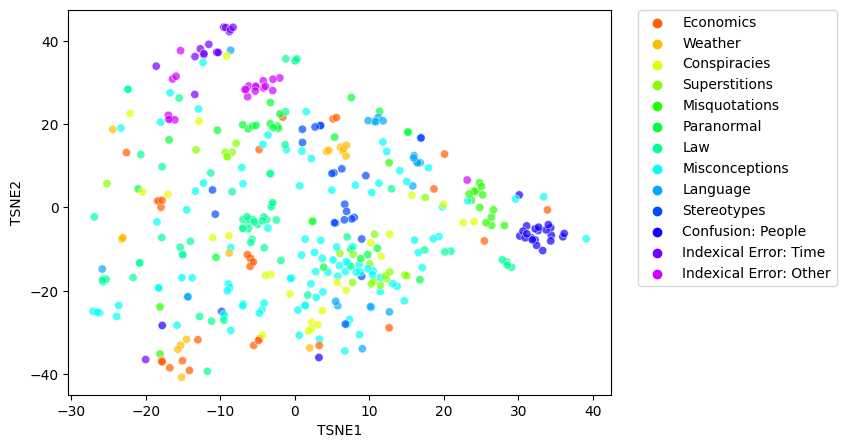

In [354]:
layer = 11
head = 6

num_questions = len(head_wise_activation_directions)
selected_categories = question_categories
selected_data = head_wise_activation_directions[:, layer, head, :]

# 求范数，获取方向向量
selected_data = selected_data / np.linalg.norm(selected_data, axis=1).reshape(-1, 1)

# 使用K-means进行聚类，分成几个大类
num_clusters = 15
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
clusters = kmeans.fit_predict(selected_data)

df = pd.DataFrame(selected_data)
df['Category'] = selected_categories
df['Cluster'] = clusters

# 使用t-SNE对所有样本进行降维
tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(selected_data) # 除去Category和Cluster列
df_tsne = pd.DataFrame(df_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Category'] = df['Category']


# 计算每个小类在每个大类中的占比评分
category_cluster_proportion = df.groupby(['Category', 'Cluster']).size().groupby(level=0).apply(lambda x: x / float(x.sum()))

# 设置样本数阈值 k
k = 15

# 对于每个大类，找出评分最高且样本数大于等于k的小类
top_categories_per_cluster = []
for cluster in range(num_clusters):
    # 获取当前大类中的小类评分
    cluster_scores = category_cluster_proportion[:, cluster]
    
    # 按评分排序
    sorted_scores = cluster_scores.sort_values(ascending=False)
    
    # 检查每个小类的样本数，选择满足条件的最高评分小类
    for category in sorted_scores.index:
        if df[(df['Category'] == category)].shape[0] > k:
            top_categories_per_cluster.append(category)
            break

# 仅在可视化中展示筛选出的小类
df_selected_tsne = df_tsne[df_tsne['Category'].isin(top_categories_per_cluster)]

# 可视化每个大类中评分最高的小类
plt.figure(figsize=(7, 5))
# scatter = sns.scatterplot(x='TSNE1', y='TSNE2', hue='Category',style='Cluster', data=df_selected, legend="full", palette=sns.color_palette("hsv", n_colors=len(highest_score_categories)), alpha=0.7)
scatter = sns.scatterplot(x='TSNE1', y='TSNE2', hue='Category', data=df_selected_tsne, legend="full", palette=sns.color_palette("hsv", n_colors=num_clusters), alpha=0.7)
# 将图例放在图表外部
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

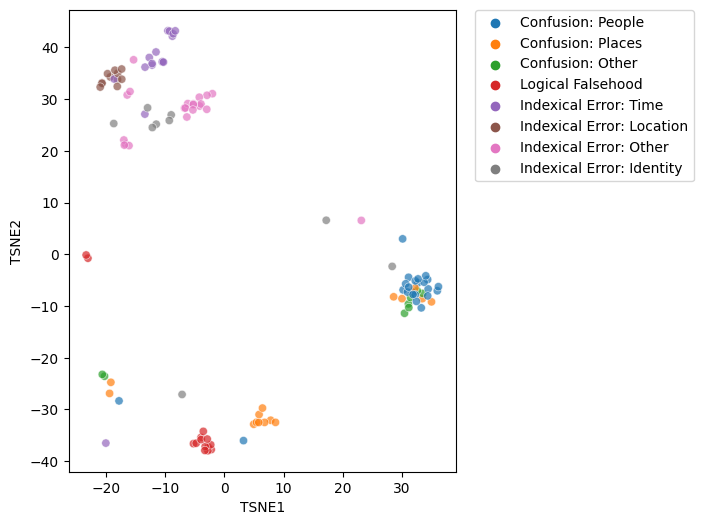

In [362]:
selected = ['Confusion: People',
            'Confusion: Places',
            'Confusion: Other',
            'Logical Falsehood',
            'Indexical Error: Time',
            'Indexical Error: Location',
            'Indexical Error: Other',
            'Indexical Error: Identity',
            ]

layer = 11
head = 6

selected_data = head_wise_activation_directions[:, layer, head, :]
# 求范数，获取方向向量
selected_data = selected_data / np.linalg.norm(selected_data, axis=1).reshape(-1, 1)

tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(selected_data)
df_tsne = pd.DataFrame(df_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Category'] = question_categories

df_tsne_select = df_tsne[df_tsne['Category'].isin(selected)]

plt.figure(figsize=(5, 6))
scatter = sns.scatterplot(x='TSNE1', 
                          y='TSNE2', 
                          hue='Category', 
                          hue_order=selected,
                          data=df_tsne_select, 
                          legend="full", 
                          alpha=0.7
                          )
# 将图例放在图表外部
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

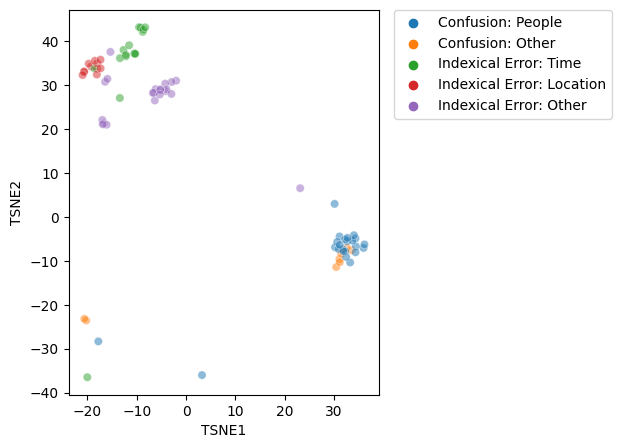

In [384]:
selected = ['Confusion: People',
            'Confusion: Other',
            'Indexical Error: Time',
            'Indexical Error: Location',
            'Indexical Error: Other',
            ]

layer = 11
head = 6

selected_data = head_wise_activation_directions[:, layer, head, :]
# 求范数，获取方向向量
selected_data = selected_data / np.linalg.norm(selected_data, axis=1).reshape(-1, 1)

tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(selected_data)
df_tsne = pd.DataFrame(df_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Category'] = question_categories

df_tsne_select = df_tsne[df_tsne['Category'].isin(selected)]

plt.figure(figsize=(4, 5))
scatter = sns.scatterplot(x='TSNE1', 
                          y='TSNE2', 
                          hue='Category', 
                          hue_order=selected,
                          data=df_tsne_select, 
                          legend="full",
                          # s=100,
                          palette=sns.color_palette("hsv", n_colors=len(selected))
                          alpha=0.5
                          )
# 将图例放在图表外部
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

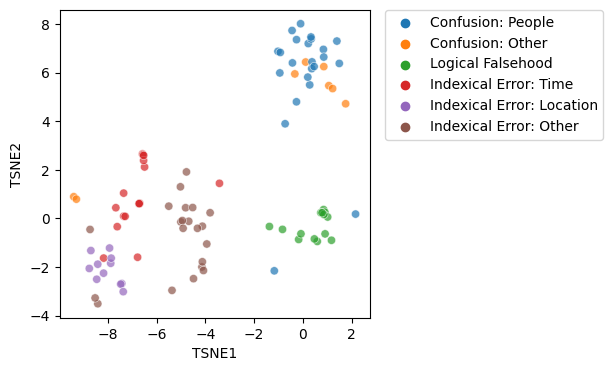

In [392]:
selected = ['Confusion: People',
            'Confusion: Other',
            'Logical Falsehood',
            'Indexical Error: Time',
            'Indexical Error: Location',
            'Indexical Error: Other',
            ]
selected_idx = [i for i, sel in enumerate(question_categories) if sel in selected]
selected_data = head_wise_activation_directions[selected_idx, layer, head, :]
selected_categories = [question_categories[i] for i in selected_idx]
# 求范数，获取方向向量
selected_data = selected_data / np.linalg.norm(selected_data, axis=1).reshape(-1, 1)

tsne = TSNE(n_components=2, random_state=0)
df_tsne = tsne.fit_transform(selected_data)
df_tsne = pd.DataFrame(df_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Category'] = selected_categories

plt.figure(figsize=(4, 4))
scatter = sns.scatterplot(x='TSNE1', 
                          y='TSNE2', 
                          hue='Category', 
                          hue_order=selected,
                          data=df_tsne,
                          legend="full", 
                          alpha=0.7,
                          )
# 将图例放在图表外部
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [329]:
categories

['Misquotations',
 'History',
 'Misconceptions: Topical',
 'Proverbs',
 'Indexical Error: Other',
 'Mandela Effect',
 'Subjective',
 'Science',
 'Fiction',
 'Logical Falsehood',
 'Confusion: Other',
 'Indexical Error: Location',
 'Health',
 'Conspiracies',
 'Nutrition',
 'Politics',
 'Advertising',
 'Religion',
 'Stereotypes',
 'Sociology',
 'Education',
 'Confusion: People',
 'Confusion: Places',
 'Superstitions',
 'Language',
 'Distraction',
 'Paranormal',
 'Misinformation',
 'Indexical Error: Identity',
 'Psychology',
 'Statistics',
 'Law',
 'Myths and Fairytales',
 'Indexical Error: Time',
 'Weather',
 'Economics',
 'Misconceptions',
 'Finance']

In [101]:
# 根据探针准确率最高的heads做聚类

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
np.random.seed(2023)

def get_top_heads(X, y, num_layers, num_heads, num_to_intervene):

    all_head_accs = []

    train_set_idxs = np.random.choice(range(len(y)), size=int(len(X) * 0.8), replace=False)
    val_set_idxs = np.array([x for x in range(len(y)) if x not in train_set_idxs])

    all_X_train = np.concatenate([X[i] for i in train_set_idxs], axis = 0)
    all_X_val = np.concatenate([X[i] for i in val_set_idxs], axis = 0)
    y_train = np.concatenate([y[i] for i in train_set_idxs], axis = 0)
    y_val = np.concatenate([y[i] for i in val_set_idxs], axis = 0)
    
    for layer in tqdm(range(num_layers), desc='train probes'): 
        for head in range(num_heads): 
            X_train = all_X_train[:,layer,head,:]
            X_val = all_X_val[:,layer,head,:]

            clf = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)
            y_pred = clf.predict(X_train)
            y_val_pred = clf.predict(X_val)
            all_head_accs.append(accuracy_score(y_val, y_val_pred))

    all_head_accs_np = np.array(all_head_accs)
    top_accs = np.argsort(all_head_accs_np.reshape(num_heads*num_layers))[::-1][:num_to_intervene] # 排序后反转取索引
    top_heads = [flattened_idx_to_layer_head(idx, num_heads) for idx in top_accs]  # 准确率最高的层和head的索引
    print("top accs", all_head_accs_np[top_accs])
    return top_heads

top_heads = get_top_heads(separated_head_wise_activations, separated_labels, 32, 32, 32*32)
top_heads

train probes: 100%|██████████| 32/32 [00:34<00:00,  1.09s/it]

top accs [0.82412914 0.81903144 0.81648258 ... 0.55819881 0.55480034 0.5531011 ]


[(11, 8),
 (11, 21),
 (11, 0),
 (13, 16),
 (11, 6),
 (15, 20),
 (11, 31),
 (18, 9),
 (14, 14),
 (10, 1),
 (10, 22),
 (18, 17),
 (11, 3),
 (9, 20),
 (14, 12),
 (18, 0),
 (16, 13),
 (17, 31),
 (15, 28),
 (13, 22),
 (12, 14),
 (10, 28),
 (17, 1),
 (8, 12),
 (9, 29),
 (14, 18),
 (15, 24),
 (10, 17),
 (10, 15),
 (20, 30),
 (14, 22),
 (18, 10),
 (13, 11),
 (10, 29),
 (19, 9),
 (12, 3),
 (13, 30),
 (12, 9),
 (10, 18),
 (16, 26),
 (14, 30),
 (16, 17),
 (22, 4),
 (7, 10),
 (24, 20),
 (19, 6),
 (6, 28),
 (13, 17),
 (16, 10),
 (10, 27),
 (15, 8),
 (20, 9),
 (17, 21),
 (14, 0),
 (14, 5),
 (14, 4),
 (21, 22),
 (9, 19),
 (11, 29),
 (7, 5),
 (13, 23),
 (20, 19),
 (11, 15),
 (11, 28),
 (11, 1),
 (11, 16),
 (23, 18),
 (12, 21),
 (8, 15),
 (12, 24),
 (15, 21),
 (31, 6),
 (11, 5),
 (12, 12),
 (12, 2),
 (10, 2),
 (10, 7),
 (16, 7),
 (7, 27),
 (30, 13),
 (17, 4),
 (8, 20),
 (12, 25),
 (17, 12),
 (19, 19),
 (9, 11),
 (5, 14),
 (13, 1),
 (20, 21),
 (16, 25),
 (16, 12),
 (22, 18),
 (16, 2),
 (8, 5),
 (22, 7),

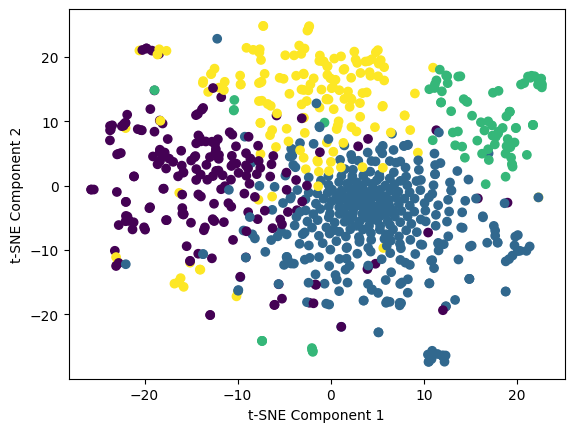

In [104]:
top_head_directions = []
for question in range(len(head_wise_activation_directions)):
    cur_top_head_directions = []
    for layer, head in np.array(top_heads)[:24]:
        cur_top_head_directions.append(head_wise_activation_directions[question, layer, head, :])
    top_head_directions.append(np.array(cur_top_head_directions).mean(axis=0))

top_head_directions = np.array(top_head_directions)

# Perform clustering
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(top_head_directions)

# Apply t-SNE on the clustered data
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(top_head_directions)

# Plot the clustered points
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## 保存directions

In [88]:
import os
os.makedirs('/data/wtl/honest_llm/directions', exist_ok=True)
np.save('/data/wtl/honest_llm/directions/head_wise_activation_directions.npy', head_wise_activation_directions)

In [322]:
a = np.array([[3,4,5], [12,15,15], [3,6,9]]) 
print(np.linalg.norm(a, axis=1))
a / np.linalg.norm(a, axis=1).reshape(-1, 1)

[ 7.07106781 24.37211521 11.22497216]


array([[0.42426407, 0.56568542, 0.70710678],
       [0.49236596, 0.61545745, 0.61545745],
       [0.26726124, 0.53452248, 0.80178373]])